In [1]:
import torch
import torch.nn as nn
from torchvision import models
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os

os.sys.path.append(os.path.dirname(os.path.abspath('.')))

from util import model_utils
from util.attribution_methods import saliencyMethods as attr
from util.attribution_methods import XRAIBuilder as XRAI_Builder
from util.attribution_methods import GIGBuilder as GIG_Builder
from util.attribution_methods import AGI as AGI
from util.attribution_methods import MACBuilder as MAC
from util.test_methods import MASTestFunctions as MAS
from util.test_methods import RISETestFunctions as RISE
from util.test_methods import PICTestFunctions as PIC
from util.modified_models import resnet
from util.visualization import attr_to_subplot


import captum.attr as attrMethods
from skimage.transform import resize as skim_resize
from skimage.segmentation import felzenszwalb
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float


device = "cuda:0"

model = models.resnet101(weights = "ResNet101_Weights.IMAGENET1K_V2")
model = model.eval()
model.to(device)

modified_model = resnet.resnet101(weights = "ResNet101_Weights.IMAGENET1K_V2")
modified_model = modified_model.eval()
modified_model.to(device)

img_hw = 224

# transform data into format needed for model model model expects 224x224 3-color image
transform = transforms.Compose([
     transforms.Resize((img_hw, img_hw)),
     transforms.CenterCrop(img_hw),
     transforms.ToTensor()
])

# standard ImageNet normalization
transform_normalize = transforms.Normalize(
     mean=[0.485, 0.456, 0.406],
     std=[0.229, 0.224, 0.225]
)

normalize = transforms.Normalize(
    (0.485, 0.456, 0.406),
    (0.229, 0.224, 0.225)
)

# invert standard ImageNet normalization
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
    std=[1/0.229, 1/0.224, 1/0.255]
)

resize = transforms.Resize((img_hw, img_hw))
crop = transforms.CenterCrop(img_hw)

In [2]:
random_mask = PIC.generate_random_mask(img_hw, img_hw, .01)

saliency_thresholds = [0.005, 0.01, 0.02, 0.03, 0.04, 0.05, 0.07, 0.10, 0.13, 0.21, 0.34, 0.5, 0.75]

def SIC_test(img_test, saliency_map):   
    saliency_map = np.abs(np.sum(saliency_map, axis = 2))
    sic_score = PIC.compute_pic_metric(img_test, saliency_map, random_mask, saliency_thresholds, 0, model, device)
    return sic_score.auc

def AIC_test(img_test, saliency_map):   
    saliency_map = np.abs(np.sum(saliency_map, axis = 2))
    aic_score = PIC.compute_pic_metric(img_test, saliency_map, random_mask, saliency_thresholds, 1, model, device)
    return aic_score.auc

klen = 11
ksig = 5
kern = RISE.gkern(klen, ksig)
blur = lambda x: nn.functional.conv2d(x, kern, padding = klen // 2)

insertion = RISE.CausalMetric(model, img_hw * img_hw, 'ins', img_hw, substrate_fn = blur)
deletion = RISE.CausalMetric(model, img_hw * img_hw, 'del', img_hw, substrate_fn = torch.zeros_like)

def ins_test(img_tensor, saliency_map):
    saliency_map_test = np.abs(np.sum(saliency_map, axis = 2))
    steps, ins = insertion.single_run(img_tensor, saliency_map_test, device)

    return RISE.auc(ins)

def del_test(img_tensor, saliency_map):
    saliency_map = np.abs(np.sum(saliency_map, axis = 2))
    _, delete = deletion.single_run(img_tensor, saliency_map, device)
    # get area under the curve
    return RISE.auc(delete)

MAS_insertion = MAS.MASMetric(model, img_hw * img_hw, 'ins', img_hw, substrate_fn = blur)
MAS_deletion = MAS.MASMetric(model, img_hw * img_hw, 'del', img_hw, substrate_fn = torch.zeros_like)

def new_ins_test(img_tensor, saliency_map, print = 0):
    saliency_map_test = np.abs(np.sum(saliency_map, axis = 2))
    steps, corrected_score, error, density, raw_score = MAS_insertion.single_run(img_tensor, saliency_map_test, device)

    return MAS.auc(corrected_score)


def new_del_test(img_tensor, saliency_map, print = 0):
    saliency_map_test = np.abs(np.sum(saliency_map, axis = 2))
    steps, corrected_score, error, density, raw_score = MAS_deletion.single_run(img_tensor, saliency_map_test, device)

    return MAS.auc(corrected_score)


In [5]:
import os 
# 623, 12, 13, 102, 369, 228, 5026, 53

# jet 7311
# balloon 18230
# parachute 15689

image_path = "../../ImageNet/ILSVRC2012_val_00011897.JPEG"
# # # image_path = "../small_objects_25/ILSVRC2012_val_00003064.JPEG"
# # # image_path = "/Users/chase/Desktop/ImageNet/ILSVRC2012_img_val/ILSVRC2012_val_00002277.JPEG"

# # # path = "../imagenet"
# path = "../small_objects_25"
# # # path = "../small_objects_50"

# images = os.listdir(path)
# print(len(images))
# image_path = path + "/" + images[100]

40.70039987564087


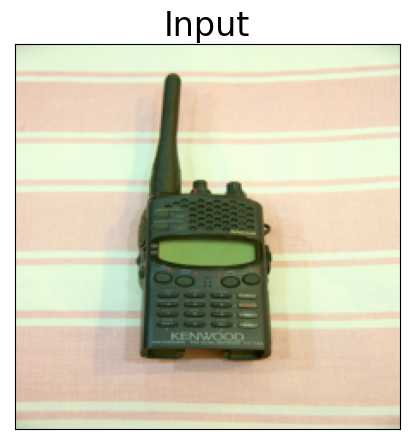

In [6]:
########  IG  LIG,  IDG  ########
img = Image.open(image_path)
img = transform(img)

# put the image in form needed for prediction for the ins/del method
img_tensor = transform_normalize(img)
img_tensor_IG_LIG_IDG = torch.unsqueeze(img_tensor, 0)

target_class = model_utils.getClass(img_tensor_IG_LIG_IDG, model, device)

print(model_utils.getPrediction(img_tensor_IG_LIG_IDG, model, device, target_class)[0] * 100)

plt.rcParams.update({'font.size': 20})
fig, axs = plt.subplots(1, 1, figsize = (5, 5))
attr_to_subplot(img, "Input", axs, original_image=True)
plt.show()
plt.close(fig)

########  IG  ########
ig = attr.IG(img_tensor_IG_LIG_IDG, model, 50, 50, 1, 0, device, target_class)
ig = np.transpose(ig.squeeze().detach().cpu().numpy(), (1, 2, 0))

########  LIG  ########
lig = attr.IG(img_tensor_IG_LIG_IDG, model, 50, 50, .9, 0, device, target_class)
lig = np.transpose(lig.squeeze().detach().cpu().numpy(), (1, 2, 0))

########  IDG  ########
idg = attr.IDG(img_tensor_IG_LIG_IDG, model, 50, 50, 0, device, target_class)
idg = np.transpose(idg.squeeze().detach().cpu().numpy(), (1, 2, 0))

# image for AIC/SIC test
AIC_img = np.transpose(img.squeeze().detach().numpy(), (1, 2, 0))

In [8]:
########  GIG  ########
# Boilerplate methods.
def LoadImage(file_path, resize, crop):
    im = Image.open(file_path)
    im = resize(im)
    im = crop(im)
    im = np.asarray(im)
    return im

def PreprocessImages(images):
    images = np.array(images)
    images = images/255
    images = np.transpose(images, (0,3,1,2))
    images = torch.tensor(images, dtype=torch.float32)
    images = normalize.forward(images)
    return images.requires_grad_(True)

# returns the class of an image 
def getClassGIG(input, model, device):
    # calculate a prediction
    input = input.to(device)
    output = model(input)

    _, index = torch.max(output, 1)

    # open the class list so the detected class string can be returned for printing
    with open('../util/class_maps/ImageNet/imagenet_classes.txt') as f:
        classes = [line.strip() for line in f.readlines()]

    return index[0], classes[index[0]]

class_idx_str = 'class_idx_str'
def call_model_function(images, model, device, call_model_args = None, expected_keys = None):
    images = PreprocessImages(images)
    target_class_idx = call_model_args[class_idx_str]
    output = model(images.to(device))
    
    # capture the logit before the output is crushed by softmax
    logit = ((output[0])[target_class_idx]).detach().cpu().numpy().item()

    m = torch.nn.Softmax(dim=1)
    output = m(output)

    if GIG_Builder.INPUT_OUTPUT_GRADIENTS in expected_keys:
        outputs = output[:,target_class_idx]
        grads = torch.autograd.grad(outputs, images, grad_outputs=torch.ones_like(outputs))[0]
        grads = torch.movedim(grads, 1, 3)
        gradients = grads.detach().numpy()
        
        return {GIG_Builder.INPUT_OUTPUT_GRADIENTS: gradients}, logit

im_orig = LoadImage(image_path, resize, crop)
img_tensor_GIG = PreprocessImages([im_orig])

# get the class
prediction_class, _ = getClassGIG(img_tensor_GIG, model, device)
prediction_class = prediction_class.item()
call_model_args = {class_idx_str: prediction_class}

# make sal map
im = im_orig.astype(np.float32)
guided_ig = GIG_Builder.GuidedIG()
baseline = np.zeros(im.shape)
gig = guided_ig.GetMask(im, model, device, call_model_function, call_model_args, x_baseline=baseline, x_steps=50, max_dist=1.0, fraction=0.5)


########  AGI  ########
def threshold(saliency_map, lowerbound = 10, upperbound = 99, img_hw = 224):
    hm = saliency_map
    hm = np.mean(hm, axis=0)
    l = np.percentile(hm, lowerbound)
    u = np.percentile(hm, upperbound)

    hm[hm < l] = l
    hm[hm > u] = u

    hm = (hm - l)/(u - l)

    saliency_map = np.reshape(hm, (img_hw, img_hw, 1))
    
    return saliency_map

# set up new AGI model
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
norm_layer = AGI.Normalize(mean, std)
AGI_model = nn.Sequential(norm_layer, model).to(device)

epsilon = 0.05
max_iter = 20
topk = 1
# define the ids of the selected adversarial class
selected_ids = range(0, 999, int(1000 / topk)) 

agi_img = AGI.LoadImage(image_path, resize, crop)
agi_img = agi_img.astype(np.float32) 

# Run test
example = AGI.test(AGI_model, device, agi_img, epsilon, topk, selected_ids, max_iter)
agi = example[2]

agi_n = np.transpose(agi, (1, 2, 0))
agi_t = threshold(agi)  * np.ones((224, 224, 3))

img_tensor = torch.tensor(np.transpose(agi_img / 255, (2, 0, 1)))
img_tensor = torch.unsqueeze(img_tensor, 0)
img_tensor_AGI = transform_normalize(img_tensor)

agi = agi_t
# agi = agi_n

In [9]:
######## GC, GGC, GBP ########

#### GC ####
layer = model.layer4
# layer = model.conv_proj

layer_gc = attrMethods.LayerGradCam(model, layer)
img_tensor_IG_LIG_IDG.requires_grad = True
gc = layer_gc.attribute(img_tensor_IG_LIG_IDG.to("cuda:0"),  target_class, relu_attributions=True)
torch.cuda.empty_cache()
gc = skim_resize(gc.squeeze().cpu().detach().numpy(), (224, 224), preserve_range=True)
gc = torch.tensor(gc).reshape((1, 224, 224)) * torch.ones((3, 224, 224))
gc = np.transpose(gc.squeeze().detach().cpu().numpy(), (1, 2, 0))

#### GGC ####
guided_gc = attrMethods.GuidedGradCam(modified_model, modified_model.layer4)
# guided_gc = attrMethods.GuidedGradCam(modified_model, modified_model.conv_proj)
ggc = guided_gc.attribute(img_tensor_IG_LIG_IDG.to("cuda:0"), target_class)
ggc = np.transpose(ggc.squeeze().detach().cpu().numpy(), (1, 2, 0))

#### GBP ####
guided_bp = attrMethods.GuidedBackprop(modified_model)
gbp = guided_bp.attribute(img_tensor_IG_LIG_IDG.to("cuda:0"), target = target_class)
gbp = np.transpose(gbp.squeeze().detach().cpu().numpy(), (1, 2, 0))

# plt.rcParams.update({'font.size': 12})
# fig, axs = plt.subplots(1, 3, figsize = (15, 5))

# attr_to_subplot(gc, "GC", axs[0], cmap = default_cmap)
# attr_to_subplot(ggc, "GGC", axs[1], cmap = default_cmap)
# attr_to_subplot(gbp, "GBP", axs[2], cmap = default_cmap)
# plt.show()
# plt.close(fig)

img_tensor_IG_LIG_IDG.requires_grad = False

/home/chasewalker/.local/lib/python3.10/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:64: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(


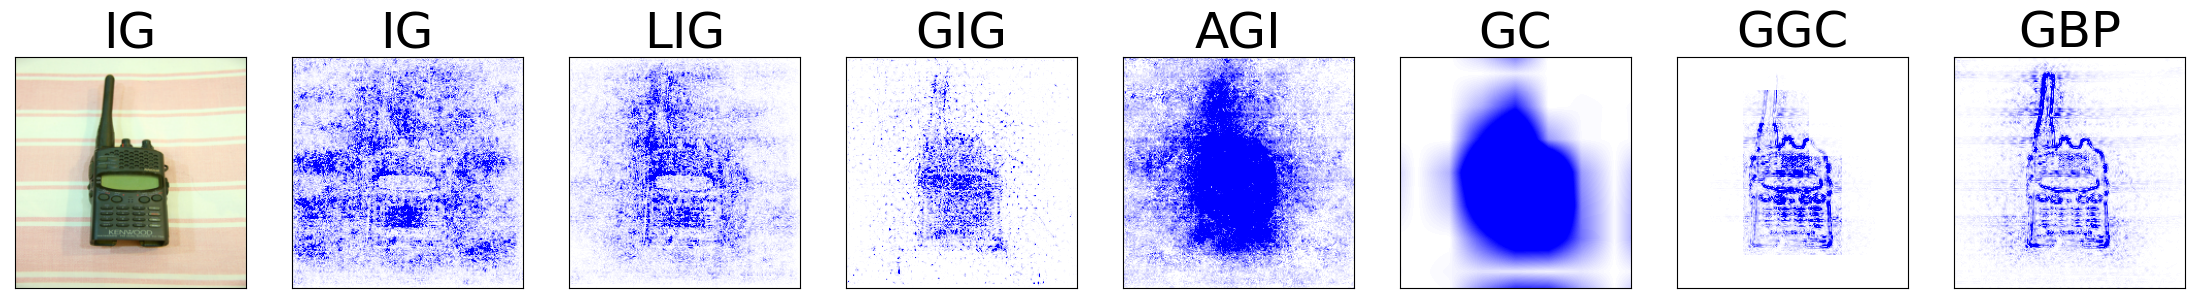

In [10]:
# save the attributions to a PDF
plt.rcParams.update({'font.size': 30})
fig, axs = plt.subplots(1, 8, figsize = (28, 7))

norm = "absolute"

attr_to_subplot(img, "IG", axs[0], original_image = True)
attr_to_subplot(ig, "IG", axs[1], norm = norm)
attr_to_subplot(lig, "LIG", axs[2], norm = norm)
attr_to_subplot(gig, "GIG", axs[3], norm = norm)
attr_to_subplot(agi, "AGI", axs[4], norm = norm)
attr_to_subplot(gc, "GC", axs[5], norm = norm)
attr_to_subplot(ggc, "GGC", axs[6], norm = norm)
attr_to_subplot(gbp, "GBP", axs[7], norm = norm)


plt.show()
plt.close(fig)

/home/chasewalker/Desktop/XAIcode/code_new/util/visualization.py:5: RuntimeWarning: invalid value encountered in divide
  attr_norm = attr / scale_factor


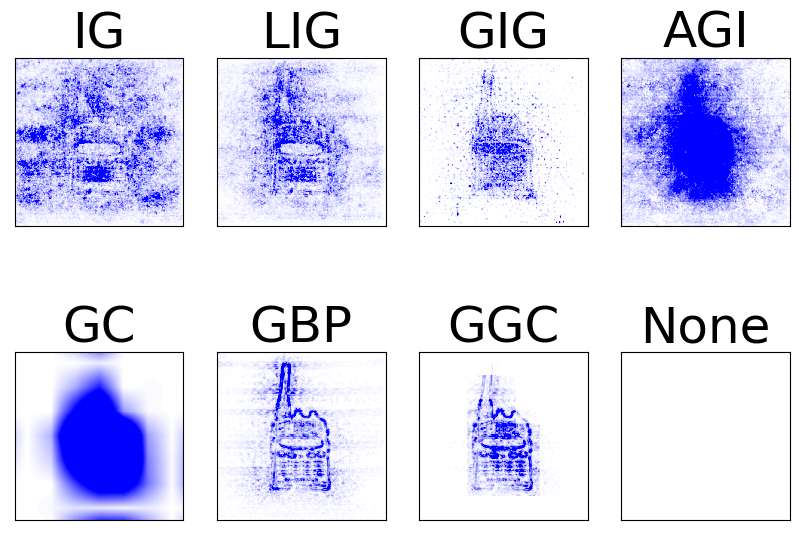

In [11]:
plt.rcParams.update({'font.size': 30})
fig, axs = plt.subplots(2, 4, figsize = (10, 7))

norm = "absolute"
# norm = "positive"
# norm = "negative"
# # norm = "all"

attr_to_subplot(ig, "IG", axs[0, 0], norm = norm)
attr_to_subplot(lig, "LIG", axs[0, 1], norm = norm)
attr_to_subplot(gig, "GIG", axs[0, 2], norm = norm)
attr_to_subplot(agi, "AGI", axs[0, 3], norm = norm)
attr_to_subplot(gc, "GC", axs[1, 0], norm = norm)
attr_to_subplot(gbp, "GBP", axs[1, 1], norm = norm)
attr_to_subplot(ggc, "GGC", axs[1, 2], norm = norm)
attr_to_subplot(np.zeros((224, 224, 3)), "None", axs[1, 3], norm = norm)


plt.show()
plt.close(fig)

In [12]:
def smoothgrad(attr_img, img_hw, model, target_class, device, sigma_spread = .15, samples = 25):
    # make input image a tensor in case it isn't
    img = torch.Tensor(attr_img)
    stdev = sigma_spread * (torch.max(img) - torch.min(img))
    total_gradients = np.zeros_like((img_hw, img_hw, 3), dtype=np.float32)

    for _ in range(samples):
        noise = torch.normal(mean = 0, std = stdev, size = attr_img.shape)

        noisy_img = attr_img + noise

        # #### IG ####
        # saliency_map, _, _ = attr.IGParallel(noisy_img, model, 50, 50, 1, 0, device, target_class)

        # #### LIG ####
        # saliency_map, _, _ = attr.IGParallel(noisy_img, model, 50, 50, 0.9, 0, device, target_class)

        # #### GC ####
        # layer = model.layer4
        # # layer = model.conv_proj
        # layer_gc = attrMethods.LayerGradCam(model, layer)
        # img.requires_grad = True
        # gc = layer_gc.attribute(noisy_img.to("cuda:0"),  target_class, relu_attributions=True)
        # torch.cuda.empty_cache()
        # gc = skim_resize(gc.squeeze().cpu().detach().numpy(), (224, 224), preserve_range=True)
        # saliency_map = torch.tensor(gc).reshape((1, 224, 224)) * torch.ones((3, 224, 224))

        # #### GGC ####
        # guided_gc = attrMethods.GuidedGradCam(modified_model, modified_model.layer4)
        # # guided_gc = attrMethods.GuidedGradCam(modified_model, modified_model.conv_proj)
        # saliency_map = guided_gc.attribute(noisy_img.to("cuda:0"), target_class)

        # #### GBP ####
        # guided_bp = attrMethods.GuidedBackprop(modified_model)
        # saliency_map = guided_bp.attribute(noisy_img.to("cuda:0"), target = target_class)

        #### AGI ####
        epsilon = 0.05
        max_iter = 20
        topk = 1
        # define the ids of the selected adversarial class
        selected_ids = range(0, 999, int(1000 / topk)) 
        agi_img = AGI.LoadImage(image_path, resize, crop)
        agi_img = agi_img.astype(np.float32) 
        noisy_img = agi_img + np.transpose(noise.numpy().squeeze(), (1, 2, 0))
        example = AGI.test(AGI_model, device, noisy_img, epsilon, topk, selected_ids, max_iter)
        agi = example[2]
        saliency_map = np.transpose(threshold(agi) * np.ones((224, 224, 3)), (2, 0, 1))
        saliency_map = torch.from_numpy(saliency_map)

        # #### ONES ####
        # saliency_map = torch.ones((3, img_hw, img_hw))

        grad = np.transpose(saliency_map.squeeze().detach().cpu().numpy(), (1, 2, 0))

        total_gradients = total_gradients + (grad * grad)

    return total_gradients / samples

In [13]:
def full_clean(image, attr, steps):
    # initialize RISE blur kernel
    klen = 11
    ksig = 11
    kern = MAS.gkern(klen, ksig)
    blur = lambda x: nn.functional.conv2d(x, kern, padding = klen // 2)

    ins_denoiser = MAC.Denoise(model, img_hw, device, mode = 'ins', substrate_fn = blur)
    del_denoiser = MAC.Denoise(model, img_hw, device, mode = 'del', substrate_fn = torch.zeros_like)

    cleaned_attr_ins, _ = ins_denoiser.clean_attribution(image, attr, steps)
    cleaned_attr_del, _ = del_denoiser.clean_attribution(image, attr, steps)

    # normalize both attributions so they have equal impact on the ouput
    cleaned_attr_ins = cleaned_attr_ins / cleaned_attr_ins.max()
    cleaned_attr_del = cleaned_attr_del / cleaned_attr_del.max()

    return cleaned_attr_ins + cleaned_attr_del

In [14]:
def get_XRAI(saliency_map):
    # Construct the saliency object. This alone doesn't do anthing.
    xrai_object = XRAI_Builder.XRAI()
    # Load the image for GIG
    im_orig = LoadImage(image_path, resize, crop)
    call_model_args = {class_idx_str: target_class.item()}
    im = im_orig.astype(np.float32)

    # Compute XRAI attributions with default parameters
    xrai = xrai_object.GetMask(im, call_model_function, call_model_args, base_attribution = saliency_map)
    xrai = xrai.reshape(224, 224, 1)
    return xrai

In [15]:
# selected_attr = np.ones((img_hw, img_hw, 3))
selected_attr = agi

In [16]:
# IG, LIG
# sg = smoothgrad(img, 224, model, target_class, device)
# GC, GGC, GBP, AGI
sg = smoothgrad(img_tensor_IG_LIG_IDG, img_hw, model, target_class, device)

In [17]:
xrai = get_XRAI(selected_attr)

In [18]:
gc_attr = gc * selected_attr

In [19]:
MAC_attr = full_clean(img_tensor_IG_LIG_IDG, selected_attr, 100)

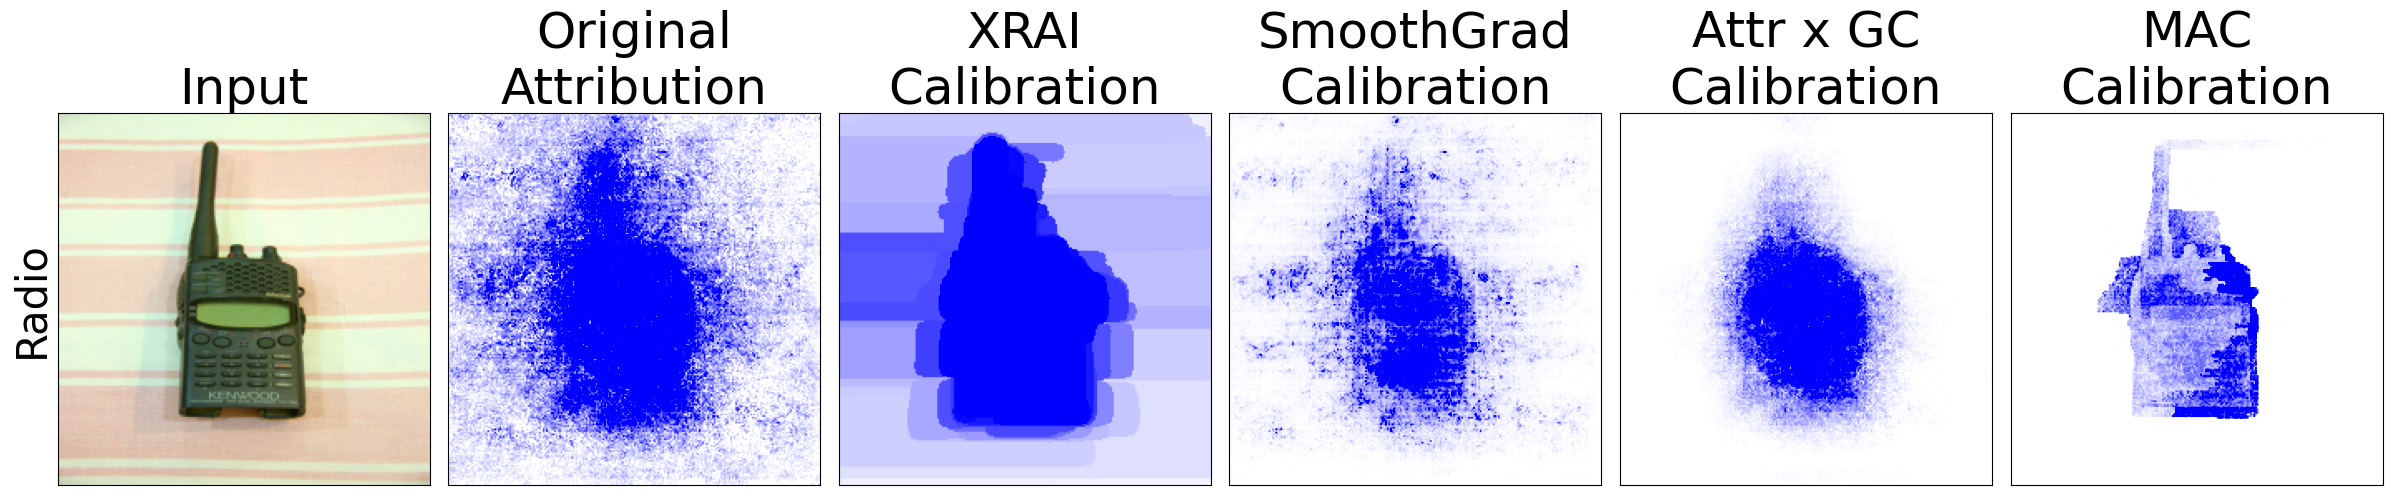

In [20]:
plt.rcParams.update({'font.size': 30})
fig, axs = plt.subplots(1, 6, figsize = (30, 5))

norm = "absolute"

axs[0].set_ylabel("Radio")
attr_to_subplot(img, "Input", axs[0], original_image=True)
attr_to_subplot(selected_attr, "Original\nAttribution", axs[1], norm = norm)
attr_to_subplot(xrai, "XRAI\nCalibration", axs[2], norm = norm)
attr_to_subplot(sg, "SmoothGrad\nCalibration", axs[3], norm = norm)
attr_to_subplot(gc_attr, "Attr x GC\nCalibration", axs[4], norm = norm)
attr_to_subplot(MAC_attr, "MAC\nCalibration", axs[5], norm = norm)

plt.subplots_adjust(wspace = 0.05)
plt.show()
plt.close(fig)

In [21]:
# plt.rcParams.update({'font.size': 35})
# fig, axs = plt.subplots(2, 1, figsize = (7, 10))

# norm = "absolute"

# attr_to_subplot(img, "Parachute", axs[0], original_image=True)
# attr_to_subplot(selected_attr, "Attribution", axs[1], norm = norm)
# plt.subplots_adjust(wspace = 0.01)
# plt.show()
# plt.close(fig)

# plt.rcParams.update({'font.size': 35})
# fig, axs = plt.subplots(4, 1, figsize = (7, 19))

# norm = "absolute"

# attr_to_subplot(xrai, "", axs[0], norm = norm)
# attr_to_subplot(sg, "", axs[1], norm = norm)
# attr_to_subplot(gc_attr, "", axs[2], norm = norm)
# attr_to_subplot(MAC_attr, "", axs[3], norm = norm)
# plt.subplots_adjust(wspace = 0.01, hspace = 0.05)
# plt.show()
# plt.close(fig)